In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# fpath='/content/drive/MyDrive/recipes/'

Mounted at /content/drive


In [3]:
!pip install tomotopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.5 MB 5.1 MB/s 


In [2]:
import matplotlib.pyplot as plt
import wordcloud as wc
import pandas as pd
import spacy
import tomotopy as tp
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
ldamodel = tp.LDAModel
spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

In [3]:
# frec = open(fpath+'RecipeNLG_dataset.csv')
# rec=frec.readlines()
number_of_documents=10000
# receitas=pd.read_csv(fpath+'RecipeNLG_dataset.csv',nrows=number_of_documents)
receitas=pd.read_csv('RecipeNLG_dataset.csv',nrows=number_of_documents)

In [4]:
# for i in range(len(rec['title'])):
#   if 'bible' in str(rec['title'][i]).lower():
#     print(rec['title'][i])
#     print(rec['ingredients'][i])
#     print(rec['directions'][i])
#     print()
#     print()
receitas.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [7]:
receitas.columns

Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER'],
      dtype='object')

In [8]:
receitas.drop(['Unnamed: 0','link','source','NER'],axis=1,inplace=True)
receitas.head()

,title,ingredients,directions
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish...."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ..."


In [9]:
receitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        10000 non-null  object
 1   ingredients  10000 non-null  object
 2   directions   10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [10]:
docs=[]
for i in range(number_of_documents):
  aux=""
  aux+=receitas['title'][i].lower().replace("("," ").replace(")"," ")+" "
  aux+=receitas['ingredients'][i].lower().replace("("," ").replace(")"," ").replace("[", "").replace("]", "").replace("\"", "").replace("tsp","tea_spoon").replace("tbsp","soup_spoon").replace("c.","cup").replace("oz","ounce").replace("lb","pound").replace("pkg","package")+" "
  aux+=receitas['directions'][i].lower().replace("("," ").replace(")"," ").replace("[", "").replace("]", "").replace("\"", "")
  docs.append(aux)

In [11]:
docslemma=[]
len_raw=[]
print('Building lemmas...')
for i,d in enumerate(docs):
  print(i,end='')
  len_raw.append(len(d))
  tdoc=nlp(d)
  lm=" ".join([token.lemma_ for token in tdoc  if not(token.is_stop == True or token.is_digit == True or token.is_punct == True or '\\' in token.lemma_ or '/' in token.lemma_)])
  docslemma.append(lm)
  print('\r\r\r\r\r\r\r\r',end='')
len_lemma=[len(d) for d in docslemma]
print('# of characters (raw,pre): (%d,%d)'%(sum(len_raw),sum(len_lemma)))
print('Average # of characters (raw,pre): (%.2f,%.2f)'%(sum(len_raw)/len(len_raw),sum(len_lemma)/len(len_lemma)))

Building lemmas...
# of characters (raw,pre): (4550928,3207276)
Average # of characters (raw,pre): (455.09,320.73)


In [12]:
for i in docslemma[:10]:
  print(i)

bake nut cookie cup firmly pack brown sugar cup evaporate milk tea_spoon vanilla cup break nuts   pecan soup_spoon butter margarine cup bite size shred rice biscuit heavy quart saucepan mix brown sugar nuts evaporate milk butter margarine stir medium heat mixture bubble boil stir minute heat stir vanilla cereal mix teaspoon drop shape cluster wax paper let stand firm minute
jewell ball chicken small jar chip beef cut boned chicken breast cream mushroom soup carton sour cream place chip beef baking dish place chicken beef mix soup cream pour chicken bake uncover hour
creamy corn   ounce   package frounceen corn   ounce   package cream cheese cube cup butter cube tea_spoon garlic powder tea_spoon salt tea_spoon pepper slow cooker combine ingredient cover cook low hour heat cheese melt stir serve yield serving
chicken funny large chicken   ounce   can chicken gravy   ounce   cream mushroom soup   ounce   box stove stuffing ounce shredded cheese boil debone chicken bite size piece average 

In [13]:
k=[]
for i in docslemma:
  k.append(i.split())
lk=len(k)
shortest=9999
longest =0
average =0
for i in k:
  test=len(i)
  if test > longest:
    longest = test
  if test < shortest:
    shortest = test
  average+=test
average/=lk
print("""number of documents: {}
shortest doc: {}
longest doc : {}
average doc : {}
""".format(lk,shortest,longest,average))

number of documents: 10000
shortest doc: 10
longest doc : 206
average doc : 50.3038



In [14]:
for i in k[:10]:
  print(i)

['bake', 'nut', 'cookie', 'cup', 'firmly', 'pack', 'brown', 'sugar', 'cup', 'evaporate', 'milk', 'tea_spoon', 'vanilla', 'cup', 'break', 'nuts', 'pecan', 'soup_spoon', 'butter', 'margarine', 'cup', 'bite', 'size', 'shred', 'rice', 'biscuit', 'heavy', 'quart', 'saucepan', 'mix', 'brown', 'sugar', 'nuts', 'evaporate', 'milk', 'butter', 'margarine', 'stir', 'medium', 'heat', 'mixture', 'bubble', 'boil', 'stir', 'minute', 'heat', 'stir', 'vanilla', 'cereal', 'mix', 'teaspoon', 'drop', 'shape', 'cluster', 'wax', 'paper', 'let', 'stand', 'firm', 'minute']
['jewell', 'ball', 'chicken', 'small', 'jar', 'chip', 'beef', 'cut', 'boned', 'chicken', 'breast', 'cream', 'mushroom', 'soup', 'carton', 'sour', 'cream', 'place', 'chip', 'beef', 'baking', 'dish', 'place', 'chicken', 'beef', 'mix', 'soup', 'cream', 'pour', 'chicken', 'bake', 'uncover', 'hour']
['creamy', 'corn', 'ounce', 'package', 'frounceen', 'corn', 'ounce', 'package', 'cream', 'cheese', 'cube', 'cup', 'butter', 'cube', 'tea_spoon', 'ga

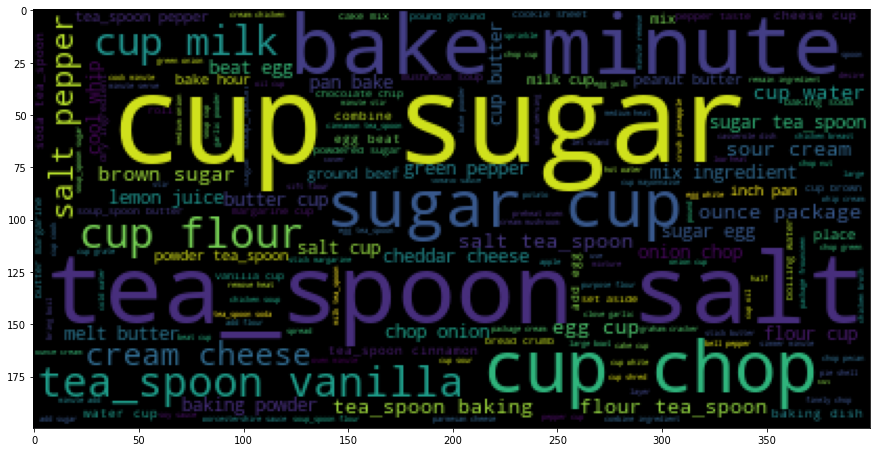

In [15]:
plt.figure(figsize=(15,15))

st=""
for i in k:
  for j in i:
    st+=j+" "
mycloud = wc.WordCloud().generate(st)
plt.imshow(mycloud)

In [16]:
sts=st.split()
distinct=set(sts)
print("number of words: {}\nnumber of unique words: {}".format(len(sts),len(distinct)))

number of words: 503038
number of unique words: 5320


In [17]:
dtoken=[simple_preprocess(d, deacc= True, min_len=3) for d in docslemma]
phrases  = Phrases(dtoken, min_count = 2,threshold=9)
bigram=Phraser(phrases)
bdocs=[bigram[d] for d in dtoken]
bdc=[]
for i in bdocs:
  st=""
  for j in i:
    st+=j+" "
  bdc.append(st)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect=TfidfVectorizer()
colTFIDF=vect.fit_transform(bdc)
print(colTFIDF.toarray())
print(vect.get_feature_names_out())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['ability' 'abington' 'able' ... 'zucchini_relish' 'zucchini_squash'
 'zwieback']


In [19]:
col_tokenized=bdocs
dict=corpora.Dictionary()
BoW=[dict.doc2bow(doc, allow_update=True) for doc in col_tokenized]
print(BoW[:20])
[print([(dict[id], count) for id, count in line]) for line in BoW[:20]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 4), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 2), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 3), (33, 2), (34, 1), (35, 1), (36, 2), (37, 1)], [(0, 1), (22, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 3), (44, 1), (45, 2), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1)], [(7, 1), (11, 1), (16, 1), (32, 1), (34, 3), (46, 1), (48, 1), (57, 2), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1)], [(0, 1), (2, 1), (3, 1), (21, 1), (30, 1), (43, 6), (46, 2), (51, 2), (53, 1), (57, 2), (68, 4), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 3), (88, 1), (89, 2), (90, 1), (91, 1),

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

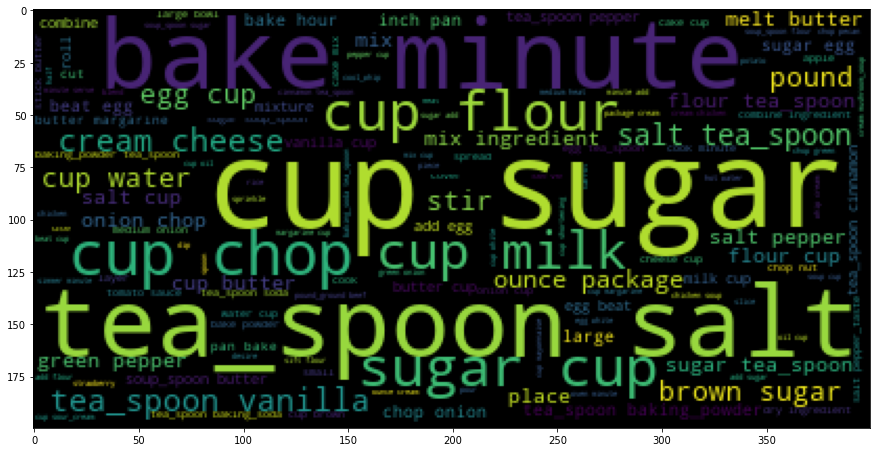

In [20]:
plt.figure(figsize=(15,15))

st=""
for i in bdocs:
  for j in i:
    st+=j+" "
mycloud = wc.WordCloud().generate(st)
plt.imshow(mycloud)